# Off Policy Learning - Evaluation with Synthetic Slate Bandit Data
---
This notebook provides an example of conducting OPE of several different evaluation policies with synthetic slate bandit data.

Our example with synthetic bandit data contains the following four major steps:
- (1) Synthetic Slate Data Generation
- (2) Defining Evaluation Policies
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

The second step could be replaced by some Off-Policy Learning (OPL) method, but obp still does not implement any OPL module for slate bandit data. Implementing OPL for slate bandits is our future work.

In [3]:
# needed when using Google Colab
# !pip install obp

In [4]:
import numpy as np
import pandas as pd
# import open bandit pipeline (obp)
import obp

from obp.ope import (
    SlateStandardIPS,
    SlateIndependentIPS,
    SlateRewardInteractionIPS,
    SlateOffPolicyEvaluation
)

from obp.dataset import (
    logistic_reward_function,
    SyntheticSlateBanditDataset,
)

In [5]:
from itertools import product
from copy import deepcopy

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# obp version
print(obp.__version__)

0.5.5


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic_reward_function` as the reward function and `linear_behavior_policy_logit` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 

n_unique_action=10
len_list = 3
dim_context = 2
reward_type = "binary"
# reward_structure="cascade_additive"
reward_structure="independent"
click_model=None
random_state=12345
base_reward_function=logistic_reward_function
# base_reward_function=None

# obtain  test sets of synthetic logged bandit data
n_rounds_test = 10000

In [33]:
# define Uniform Random Policy as a baseline behavior policy
dataset_with_random_behavior = SyntheticSlateBanditDataset(
    n_unique_action=n_unique_action,
    len_list=len_list,
    dim_context=dim_context,
    reward_type=reward_type,
    reward_structure=reward_structure,
    click_model=click_model,
    random_state=random_state,
    behavior_policy_function=None,  # set to uniform random
    base_reward_function=base_reward_function,
)

dataset_with_random_behavior

SyntheticSlateBanditDataset(n_unique_action=10, len_list=3, dim_context=2, reward_type='binary', reward_structure='independent', decay_function=<function exponential_decay_function at 0x7fd238ce09d0>, click_model=None, eta=1.0, base_reward_function=<function logistic_reward_function at 0x7fd1e8430a60>, behavior_policy_function=None, is_factorizable=False, random_state=12345, dataset_name='synthetic_slate_bandit_dataset')

In [34]:
# compute the factual action choice probabilities for the test set of the synthetic logged bandit data
bandit_feedback_with_random_behavior = dataset_with_random_behavior.obtain_batch_bandit_feedback(
    n_rounds=n_rounds_test,
    return_pscore_item_position=True,
)

[sample_action_and_obtain_pscore]: 100%|██████████| 10000/10000 [00:05<00:00, 1881.20it/s]


In [35]:
bandit_feedback_with_random_behavior

{'n_rounds': 10000,
 'n_unique_action': 10,
 'slate_id': array([   0,    0,    0, ..., 9999, 9999, 9999]),
 'context': array([[-0.20470766,  0.47894334],
        [-0.51943872, -0.5557303 ],
        [ 1.96578057,  1.39340583],
        ...,
        [ 0.3870405 ,  0.36272368],
        [ 2.65737255,  1.47234137],
        [ 1.03315414,  2.95046562]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([8, 2, 5, ..., 9, 2, 0]),
 'position': array([0, 1, 2, ..., 0, 1, 2]),
 'reward': array([0, 0, 0, ..., 1, 0, 1]),
 'expected_reward_factual': array([0.1553, 0.6787, 0.5024, ..., 0.3088, 0.6406, 0.581 ], dtype=float

In [36]:
bandit_feedback_with_random_behavior.keys()

dict_keys(['n_rounds', 'n_unique_action', 'slate_id', 'context', 'action_context', 'action', 'position', 'reward', 'expected_reward_factual', 'pscore_cascade', 'pscore', 'pscore_item_position'])

In [37]:
bandit_feedback_with_random_behavior['slate_id']

array([   0,    0,    0, ..., 9999, 9999, 9999])

In [57]:
print(bandit_feedback_with_random_behavior['context'].shape)

bandit_feedback_with_random_behavior['context']

(10000, 2)


array([[-0.20470766,  0.47894334],
       [-0.51943872, -0.5557303 ],
       [ 1.96578057,  1.39340583],
       ...,
       [ 0.3870405 ,  0.36272368],
       [ 2.65737255,  1.47234137],
       [ 1.03315414,  2.95046562]])

In [39]:
bandit_feedback_with_random_behavior['action_context']

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [40]:
bandit_feedback_with_random_behavior['action']

array([8, 2, 5, ..., 9, 2, 0])

In [41]:
bandit_feedback_with_random_behavior['position']

array([0, 1, 2, ..., 0, 1, 2])

In [42]:
bandit_feedback_with_random_behavior['reward']

array([0, 0, 0, ..., 1, 0, 1])

In [43]:
bandit_feedback_with_random_behavior['expected_reward_factual']

array([0.1553, 0.6787, 0.5024, ..., 0.3088, 0.6406, 0.581 ], dtype=float16)

In [61]:
bandit_feedback_with_random_behavior['pscore_cascade']

array([0.1       , 0.01111111, 0.00138889, ..., 0.1       , 0.01111111,
       0.00138889])

In [60]:
(0.100000 + 0.011111 + 0.001389)/3

0.0375

In [59]:
bandit_feedback_with_random_behavior['pscore']

array([0.00138889, 0.00138889, 0.00138889, ..., 0.00138889, 0.00138889,
       0.00138889])

In [48]:
1/10

0.1

In [58]:
bandit_feedback_with_random_behavior['pscore_item_position']

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [62]:
# print policy value
random_policy_value = dataset_with_random_behavior.calc_on_policy_policy_value(
    reward=bandit_feedback_with_random_behavior["reward"],
    slate_id=bandit_feedback_with_random_behavior["slate_id"],
)
print(random_policy_value)

1.4995


## (2) Evaluation Policy Definition (Off-Policy Learning)
After generating synthetic slate bandit data, we now define some evaluation policies in the following.

In [30]:
random_policy_logit_ = np.zeros((n_rounds_test, n_unique_action))

In [63]:
base_expected_reward = dataset_with_random_behavior.base_reward_function(
    context=bandit_feedback_with_random_behavior["context"],
    action_context=dataset_with_random_behavior.action_context,
    random_state=dataset_with_random_behavior.random_state,
)

base_expected_reward

array([[0.33506361, 0.56637927, 0.67872397, ..., 0.5056741 , 0.15524333,
        0.22328837],
       [0.51949486, 0.47461193, 0.64096854, ..., 0.72710054, 0.26648861,
        0.28936731],
       [0.53434843, 0.77051311, 0.86187024, ..., 0.11777036, 0.10051103,
        0.2052572 ],
       ...,
       [0.47419671, 0.60600501, 0.73857881, ..., 0.43431786, 0.17040603,
        0.24212954],
       [0.64742235, 0.81114097, 0.89782877, ..., 0.07539067, 0.09916266,
        0.21255968],
       [0.10676848, 0.78695772, 0.80059202, ..., 0.07111573, 0.03573891,
        0.11642714]])

In [64]:
optimal_policy_logit_ = base_expected_reward * 3
anti_optimal_policy_logit_ = -3 * base_expected_reward

In [65]:
optimal_policy_logit_

array([[1.00519083, 1.6991378 , 2.03617191, ..., 1.51702229, 0.46572999,
        0.66986512],
       [1.55848457, 1.4238358 , 1.92290561, ..., 2.18130163, 0.79946583,
        0.86810194],
       [1.60304528, 2.31153932, 2.58561073, ..., 0.35331108, 0.3015331 ,
        0.61577161],
       ...,
       [1.42259013, 1.81801504, 2.21573642, ..., 1.30295359, 0.51121809,
        0.72638862],
       [1.94226706, 2.4334229 , 2.6934863 , ..., 0.22617201, 0.29748798,
        0.63767905],
       [0.32030545, 2.36087317, 2.40177605, ..., 0.21334718, 0.10721672,
        0.34928143]])

In [66]:
anti_optimal_policy_logit_

array([[-1.00519083, -1.6991378 , -2.03617191, ..., -1.51702229,
        -0.46572999, -0.66986512],
       [-1.55848457, -1.4238358 , -1.92290561, ..., -2.18130163,
        -0.79946583, -0.86810194],
       [-1.60304528, -2.31153932, -2.58561073, ..., -0.35331108,
        -0.3015331 , -0.61577161],
       ...,
       [-1.42259013, -1.81801504, -2.21573642, ..., -1.30295359,
        -0.51121809, -0.72638862],
       [-1.94226706, -2.4334229 , -2.6934863 , ..., -0.22617201,
        -0.29748798, -0.63767905],
       [-0.32030545, -2.36087317, -2.40177605, ..., -0.21334718,
        -0.10721672, -0.34928143]])

In [33]:
# bandit_feedback_with_random_behavior["action"].shape

In [67]:
random_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=random_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:18<00:00, 527.60it/s]


In [68]:
random_policy_pscores

(array([0.00138889, 0.00138889, 0.00138889, ..., 0.00138889, 0.00138889,
        0.00138889]),
 array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]),
 array([0.1       , 0.01111111, 0.00138889, ..., 0.1       , 0.01111111,
        0.00138889]))

In [23]:
optimal_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=optimal_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:13<00:00, 759.05it/s]


In [24]:
anti_optimal_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=anti_optimal_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:13<00:00, 753.20it/s]


## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use 
- `SlateStandardIPS` (SIPS)
- `SlateIndependentIPS` (IIPS)
- `SlateRewardInteractionIPS` (RIPS)

and visualize the OPE results.

In [25]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

sips = SlateStandardIPS(len_list=len_list)
iips = SlateIndependentIPS(len_list=len_list)
rips = SlateRewardInteractionIPS(len_list=len_list)

ope = SlateOffPolicyEvaluation(
    bandit_feedback=bandit_feedback_with_random_behavior,
    ope_estimators=[sips, iips, rips]
)

In [69]:
print(np.sum(random_policy_pscores[0] == bandit_feedback_with_random_behavior['pscore']))

random_policy_pscores[0]

30000


array([0.00138889, 0.00138889, 0.00138889, ..., 0.00138889, 0.00138889,
       0.00138889])

In [70]:
print(np.sum(random_policy_pscores[1] == bandit_feedback_with_random_behavior['pscore_item_position']))

random_policy_pscores[1]

30000


array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [71]:
print(np.sum(random_policy_pscores[2] == bandit_feedback_with_random_behavior['pscore_cascade']))
random_policy_pscores[2]

30000


array([0.1       , 0.01111111, 0.00138889, ..., 0.1       , 0.01111111,
       0.00138889])

In [72]:
estimated_policy_value_random, estimated_interval_random = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)

estimated_interval_random["policy_name"] = "random"


estimated_policy_value_random


,estimated_policy_value,relative_estimated_policy_value
sips,1.6461,1.0
iips,1.6461,1.0
rips,1.6461,1.0


In [58]:
estimated_interval_random

,mean,95.0% CI (lower),95.0% CI (upper),policy_name
sips,1.646317,1.631293,1.662105,random
iips,1.646317,1.631293,1.662105,random
rips,1.646317,1.631293,1.662105,random


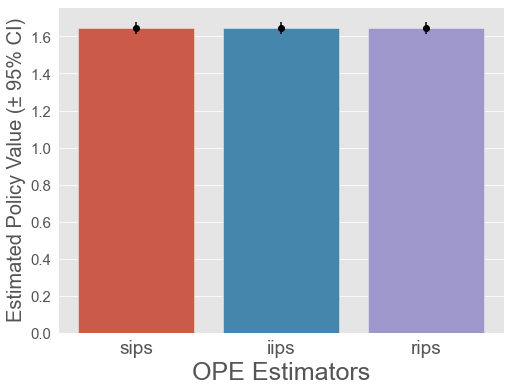

In [59]:
# visualize estimated policy values of Uniform Random by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in bootstrap sampling
    random_state=dataset_with_random_behavior.random_state,
)

In [42]:
_, estimated_interval_optimal = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_optimal["policy_name"] = "optimal"

estimated_interval_optimal

,mean,95.0% CI (lower),95.0% CI (upper),policy_name
sips,1.629474,1.585960,1.675414,optimal
iips,1.674750,1.655507,1.692978,optimal
rips,1.626834,1.594925,1.658154,optimal


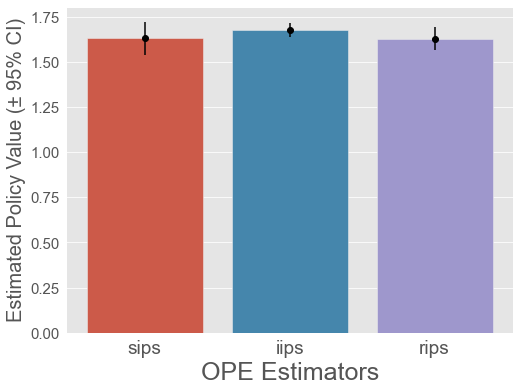

In [43]:
# visualize estimated policy values of Optimal by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in bootstrap sampling
    r`andom_state=dataset_with_random_behavior.random_state,
)

In [44]:
_, estimated_interval_anti_optimal = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_anti_optimal["policy_name"] = "anti-optimal"

estimated_interval_anti_optimal

,mean,95.0% CI (lower),95.0% CI (upper),policy_name
sips,1.691671,1.647720,1.737568,anti-optimal
iips,1.602862,1.584707,1.623184,anti-optimal
rips,1.687415,1.654940,1.722200,anti-optimal


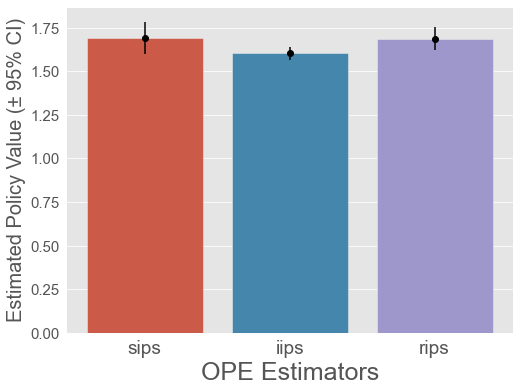

In [45]:
# visualize estimated policy values of Anti-optimal by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in bootstrap sampling
    random_state=dataset_with_random_behavior.random_state,
)

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic slate bandit data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by OPE estimators with the ground-turths to evaluate the accuracy of OPE.

In [47]:
ground_truth_policy_value_random = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=random_policy_logit_
)
ground_truth_policy_value_random

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:09<00:00, 1059.01it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


1.644826072014703

In [48]:
ground_truth_policy_value_optimal = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=optimal_policy_logit_
)
ground_truth_policy_value_optimal

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:11<00:00, 904.18it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


1.6125410474183628

In [49]:
ground_truth_policy_value_anti_optimal = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=anti_optimal_policy_logit_
)
ground_truth_policy_value_anti_optimal

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:11<00:00, 847.44it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


1.6893330966600806

In [50]:
estimated_interval_random["ground_truth"] = ground_truth_policy_value_random
estimated_interval_optimal["ground_truth"] = ground_truth_policy_value_optimal
estimated_interval_anti_optimal["ground_truth"] = ground_truth_policy_value_anti_optimal

estimated_intervals = pd.concat(
    [
        estimated_interval_random,
        estimated_interval_optimal,
        estimated_interval_anti_optimal
    ]
)

In [51]:
estimated_intervals

,mean,95.0% CI (lower),95.0% CI (upper),policy_name,ground_truth
sips,1.646317,1.631293,1.662105,random,1.644826
iips,1.646317,1.631293,1.662105,random,1.644826
rips,1.646317,1.631293,1.662105,random,1.644826
sips,1.629474,1.585960,1.675414,optimal,1.612541
iips,1.674750,1.655507,1.692978,optimal,1.612541
rips,1.626834,1.594925,1.658154,optimal,1.612541
sips,1.691671,1.647720,1.737568,anti-optimal,1.689333
iips,1.602862,1.584707,1.623184,anti-optimal,1.689333
rips,1.687415,1.654940,1.722200,anti-optimal,1.689333


We can confirm that the three OPE estimators return the same results when the behavior policy and the evaluation policy is the same, and the estimates are quite similar to the `random_policy_value` calcurated above.

We can also observe that the performance of OPE estimators are as follows in this simulation: `IIPS > RIPS > SIPS`.

In [52]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_random_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_random,
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
)
relative_ee_for_random_evaluation_policy

,se
sips,0.000002
iips,0.000002
rips,0.000002


In [53]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_optimal_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_optimal,
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
)
relative_ee_for_optimal_evaluation_policy

,se
sips,0.000283
iips,0.003849
rips,0.000201


In [54]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_anti_optimal_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_anti_optimal,
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
)
relative_ee_for_anti_optimal_evaluation_policy

,se
sips,0.000006
iips,0.007534
rips,0.000005


The variance of OPE estimators is as follows: `SIPS > RIPS > IIPS`.

In [55]:
estimated_intervals["errbar_length"] = (
    estimated_intervals.drop(["mean", "policy_name", "ground_truth"], axis=1).diff(axis=1).iloc[:, -1].abs()
)

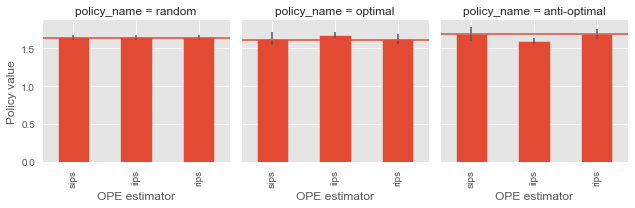

In [56]:
alpha = 0.05
plt.style.use("ggplot")

def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)
    ax.hlines(data["ground_truth"].iloc[0], -1, len(x)+1)
    
g = sns.FacetGrid(
    estimated_intervals.reset_index().rename(columns={"index": "OPE estimator", "mean": "Policy value"}),
    col="policy_name"
)
g.map_dataframe(errplot, "OPE estimator", "Policy value", "errbar_length")